**To select valid barcodes from Droplet Paired-Tag data, we performed a two-steps filtering process based on (1). Fraction of reads in peaks (FRiP) level and fragment number of DNA libraries, and (2). UMI counts from  the RNA libraries. Cells pass both filtering are deem valid barcodes and can be proceed into downstream analysis.**

In [11]:
## Load necessary pacakges
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

In [3]:
## Read metadata recording DNA - RNA pairing relationship
meta <- read.table("/projects/ps-renlab2/y2xie/projects/BICAN/exp/99.broad_sequencing_231030/01.rawdata/metadata/Multiome_pairing_seq_231119.xls", sep = "\t")
head(meta, 8)

,V1,V2,V3,V4
,<chr>,<chr>,<chr>,<chr>
1,BI001,BI003,hg38,C1-A-D2-CBV-RNA
2,BI002,BI004,hg38,C1-B-D2-CBV-RNA
3,BI005,BI013,hg38,C4-B-1-D2-CBL-RNA
4,BI006,BI014,hg38,C4-B-2-D2-CBL-NB wash-RNA
5,BI007,BI015,hg38,C4-A-D2-CBL-JE sorter-RNA
6,BI008,BI016,hg38,C4-B-3-D2-CBL-JE sorter-RNA
7,BI009,BI017,hg38,C2-A-D2-A25-RNA
8,BI010,BI018,hg38,C2-B-D2-A25-RNA


V1: DNA library  
V2: RNA library

## DNA barcodes selection

Read DNA FRiP and fragments number, which has been calculated during pre-processing  
Example: BI001, BI003

**ImportArcFRiP** will read in the raw fragment count and fragments in peaks count pre-calculated, and returns the per cell FRiP value.

In [4]:
s <- "BI001"
path <- "/projects/ps-renlab2/y2xie/projects/BICAN/exp/99.broad_sequencing_231030/"
frip <- ImportArcFRiP(raw_count = paste0(path, "09.macs2/", s, "_clean_fragments.tsv.gz_Count.xls"),
                      frip_count = paste0(path, "09.macs2/", s, "_FRiP_fragments.tsv_Count.xls"))

head(frip)

,bc,counts_total,counts_unique,counts_in_peaks,unique_in_peaks,frip
,<I<chr>>,<int>,<int>,<int>,<int>,<dbl>
1,AAACAAGCAAACAAAG-1,4,2,4,2,1.0000000
2,AAACAAGCAAACATGT-1,11,2,7,1,0.5000000
3,AAACAAGCAAACCAGC-1,6,6,2,2,0.3333333
4,AAACAAGCAAACCCAA-1,19,16,6,4,0.2500000
5,AAACAAGCAAACTAAC-1,3,3,2,2,0.6666667
6,AAACAAGCAAACTGAT-1,4,3,2,1,0.3333333


**PlotArcFRiP** will plot a FRiP-by-fragment scatter plot, and save the plot as [s]_FRiP_macs2.png in the working directory. In addition to the plot being saved, this function will return and save ([s]_PF_cells.txt) a list of cells which are selected based on the criteria specified.  
* xcut_low specifies the minimum unique fragment number to be used as cutoff
* ycut_low specifies the minimum FRiP
* ycut_high specifies the maximum FRiP

**In general, you should observe a main population with high FRiP and fragment number. This major population is the cells we want to select.**    
If the majority of FRiP is smaller than 0.2 (20%), then the library / pre-processing probably has issue.

In [14]:
# valid <- PlotArcFRiP(frip, xcut_low = 500, ycut_low = 0.3, ycut_high = 0.7, prefix = s)
valid <- PlotArcFRiP_d(frip, xcut_low = 500, ycut_low = 0.3, ycut_high = 0.7, prefix = s)

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


Let's replot the FRiP-by-fragment scatter plot:

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


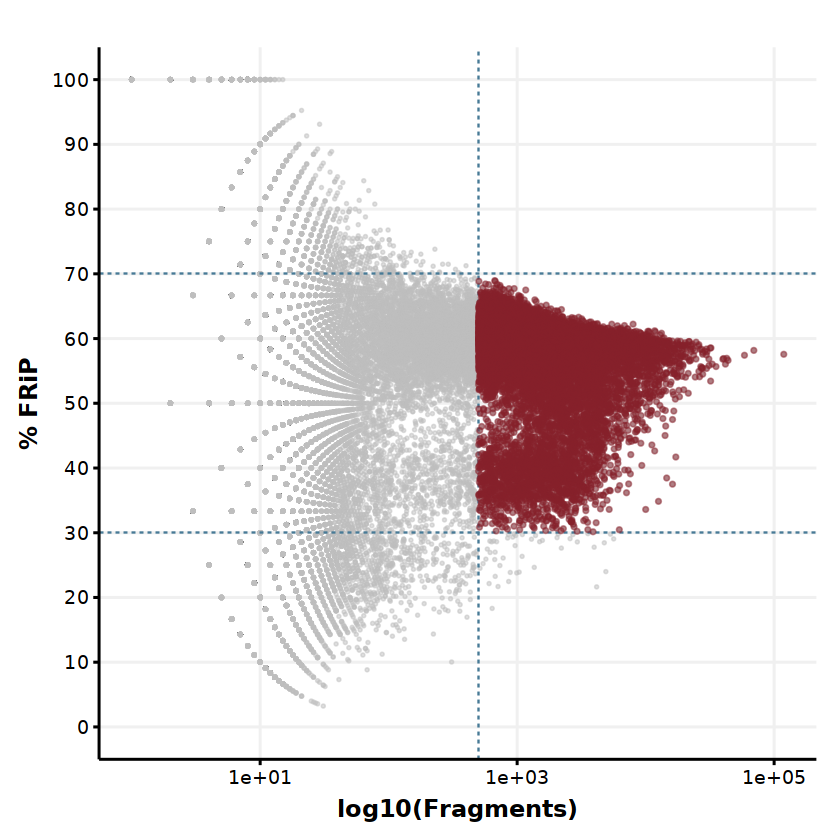

In [35]:
xcut_low <- 500
ycut_low <- 0.3
ycut_high <- 0.7

frip %>% 
ggplot(aes(x = counts_unique, y = 100 * frip)) + 
geom_point(size = 0.5, alpha = 0.5, color = "grey") + 
geom_vline(xintercept = xcut_low, color = colfunc2(1), linetype = "dashed") + 
geom_hline(yintercept = 100 * ycut_low, color = colfunc2(1), linetype = "dashed") + 
geom_hline(yintercept = 100 * ycut_high, color = colfunc2(1), linetype = "dashed") + 
geom_point(data = valid, aes(x = counts_unique, y = 100 * frip), size = 1, alpha = 0.5, color = colfunc2(3)[[2]]) + 
theme_Publication() + 
xlab("log10(Fragments)") + ylab("% FRiP") + 
scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, 10)) + 
scale_x_log10()

Let's also plot the fragment size distribution to see pattern of the fragments being tagmented. The result will also be saved as [s]_fragments.pdf in the working directory, where s is the prefix you specify.


In general, you should be able to observe nucleosomal pattern of the fragments. Depends on the histone modifications being targeted, position of the highest peak can be different.

Warning message in fread(frag_path):
“Detected 1 column names but the data has 5 columns (i.e. invalid file). Added 4 extra default column names at the end.”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


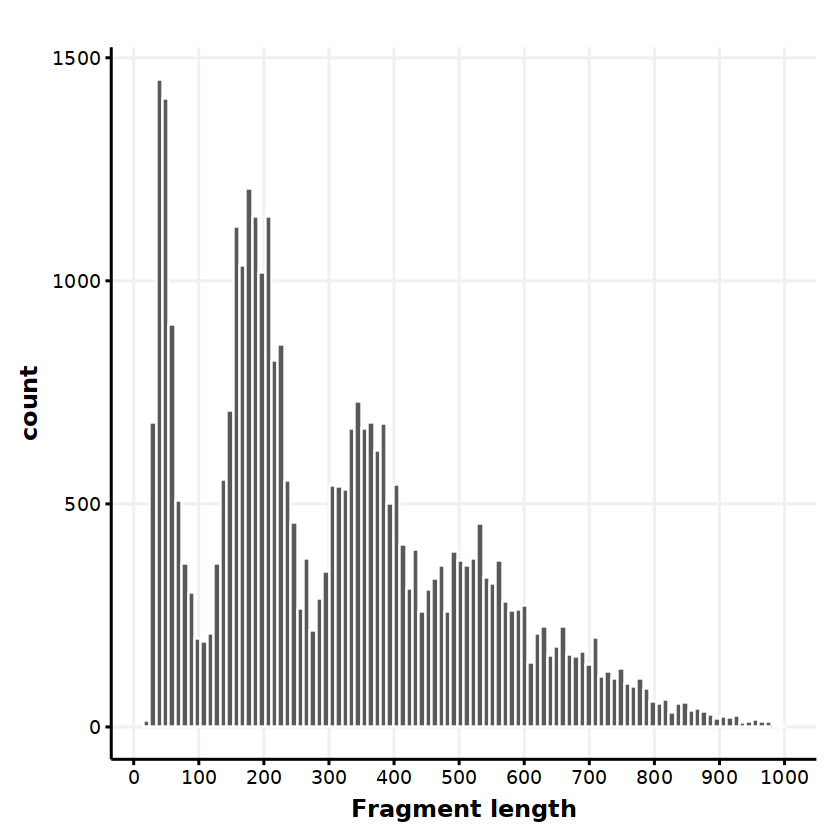

In [49]:
PlotArcFragment(frag_path = paste0(path, "/DNA/", s, "/outs/fragments.tsv.gz"), prefix = s)

## Paired filtering of DNA and RNA

Next, we are going to filter both the DNA and RNA.  
To do this, we have to manually pair the barcodes in DNA and RNA libraries, since they are naturally different.

In [6]:
translate <- read.table("/projects/ps-renlab/y2xie/projects/genome_ref/arc_bc-translation.txt", header = T, row.names = 1, sep = "\t")
translate$atac <- paste0(translate$atac, "-1")
translate$rna <- paste0(translate$rna, "-1")

head(translate)

,atac,rna,name
,<chr>,<chr>,<chr>
1,ACAGCGGGTGTGTTAC-1,AAACAGCCAAACAACA-1,arc_pair_1
2,ACAGCGGGTTGTTCTT-1,AAACAGCCAAACATAG-1,arc_pair_2
3,ACAGCGGGTAACAGGC-1,AAACAGCCAAACCCTA-1,arc_pair_3
4,ACAGCGGGTGCGCGAA-1,AAACAGCCAAACCTAT-1,arc_pair_4
5,ACAGCGGGTCCTCCAT-1,AAACAGCCAAACCTTG-1,arc_pair_5
6,ACAGCGGGTCATGGTT-1,AAACAGCCAAACGCGA-1,arc_pair_6


We need to read in the dna and rna data. The pairing relationship has been recorded in the meta we read in the beginning

In [7]:
ds <- "BI001" ### DNA sample id
rs <- "BI003" ### RNA sample id

### Read DNA all fragment:
tmp1 <- read.table(paste0(path, "/09.macs2/", ds, "_clean_fragments.tsv.gz_Count.xls")) %>% 
setNames(c("dna_raw", "dna_unique")) %>%
select(dna_unique)

### Translate DNA barcode to RNA barcode:
rownames(tmp1) <- translate[match(rownames(tmp1), translate$atac),]$rna

### Read RNA unfiltered matrix, calculated per cell UMI
tmp2 <- Seurat::Read10X(paste0(path, "/RNA/", rs, "/outs/raw_feature_bc_matrix")) %>% colSums() %>% as.data.frame() %>% setNames("rna")

### Merge based on shared barcodes name: 
tf <- merge(x = tmp1, y = tmp2, by = 0) %>% 
setNames(c("bc", "dna_count", "rna_count"))

### Check:
head(tf)

,bc,dna_count,rna_count
,<I<chr>>,<int>,<dbl>
1,AAACAGCCAAACATAG-1,1,1
2,AAACAGCCAAACCCTA-1,4,4
3,AAACAGCCAAACCTAT-1,2,1
4,AAACAGCCAAACGCGA-1,1,1
5,AAACAGCCAAACGGGC-1,3,1
6,AAACAGCCAAAGCGCA-1,6,10


**PlotArcPair** will plot a DNA-by-RNA scatter plot, and save the plot as [ds]_[rs]_valid_cells.png in the working directory. In addition to the plot being saved, this function will return a list of cells which passed the minimum counts of DNA & RNA cutoff.

* pair specifies the input paired matrix, with three fixed columns: "bc", "dna_count" and "rna_count".
* dcutoff specifies the DNA fragment cutoff value.
* rcutoff specifies the RNA UMI cutoff value.
* prefix specifies the output plot prefix.
* names indicates that in the input paired matrix, the barcode is RNA barcode. PlotArcPair will add the barcode from the other modality to the final cell list. 

In [12]:
valid <- PlotArcPair_d(pair = tf, dcutoff = 500, rcutoff = 700, 
                      prefix = paste0(ds, "_", rs), names = "rna")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


Let's replot the DNA-by-RNA scatter plot:

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


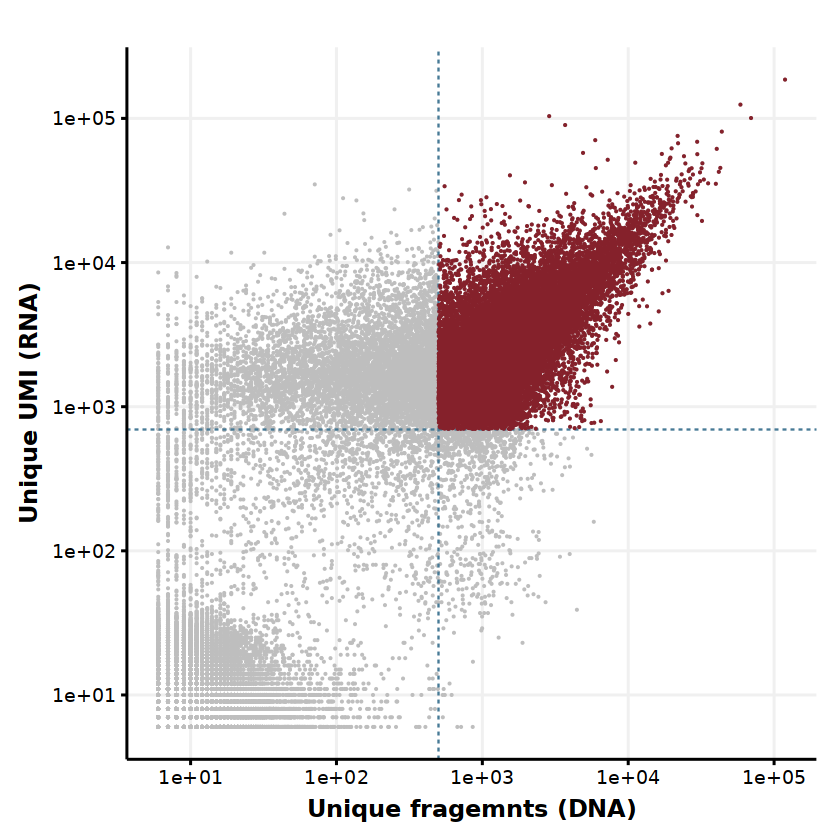

In [53]:
dcutoff <- 500
rcutoff <- 700

tf %>% 
dplyr::filter(dna_count > 5 & rna_count > 5) %>% 
ggplot(aes(x = dna_count, y = rna_count)) + 
geom_point(size = 0.1, color = "grey") + 
geom_vline(xintercept = dcutoff, color = colfunc2(1), linetype = "dashed") + 
geom_hline(yintercept = rcutoff, color = colfunc2(1), linetype = "dashed") + 
geom_point(data = tf[tf$dna_count > dcutoff & tf$rna_count > rcutoff, ], 
           aes(x = dna_count, y = rna_count), size = 0.1, color = colfunc2(3)[[2]]) + 
theme_Publication() + 
ylab("Unique UMI (RNA)") + xlab("Unique fragemnts (DNA)") + 
scale_x_log10() + scale_y_log10()

Let's check the returned cell list. **This will be automatically saved so no worry**.

In [45]:
head(valid)

,rna,atac,dna_count,rna_count
,<chr>,<chr>,<int>,<dbl>
1,AAACAGCCAACAACAA-1,ACAGCGGGTTCAATTG-1,1019,1833
2,AAACAGCCACAACAAA-1,ACAGCGGGTTACGAAG-1,16447,23743
3,AAACAGCCACGAATTT-1,ACAGCGGGTACCGTGC-1,709,1413
4,AAACAGCCAGGCTAGA-1,ACAGCGGGTTGGCGGA-1,577,2346
5,AAACAGCCAGTTATGT-1,ACAGCGGGTTTGCAGT-1,2031,3096
6,AAACAGCCATAATGTC-1,ACAGCGGGTGCAAGTA-1,1424,4573


Now we have obtained the valid barcode for both RNA and DNA modalitty for downstream analysis

# QC filtering for preindexed sample

preindex sample, or sample with name starting with **"M"** in the metadata, contains mixture of multiple different samples. This allows us to initially load more cells than typically permitted, and later those multiplet cells can be computationally identified and removed.   

To do this, we add a short barcode sequence (2-3bp) on the pA-Tn5 adapter, and performed CUT&Tag process separately for each sample. After tagmentation, samples are pooled together and proceed to load 10X controller. At the end of our analysis workflow, for each RNA files, we will have three different DNA files, and we have to process them individually. For example,

In [4]:
meta[grep('^M', meta$V4), ] %>% head

,V1,V2,V3,V4
,<chr>,<chr>,<chr>,<chr>
30,BI075,BI087,hg38,M1-1-D1-CBV-2nt-
31,BI076,BI088,hg38,M1-2-D1-CBV-2nt-
32,BI077,BI089,hg38,M2-1-D1-CBL-3nt-
33,BI078,BI090,hg38,M2-2-D1-CBL-3nt-
34,BI091,BI107,hg38,M3-1
35,BI092,BI108,hg38,M3-2


We will use BI075 and BI087 as an example. You should be able to find two FRiP files for BI075:

In [10]:
s <- "BI075"
path <- "/projects/ps-renlab2/y2xie/projects/BICAN/exp/99.broad_sequencing_231030/"

### we use some regex to try listing all the files start with `BI075_H3` and ends with `_Count.xls`
tfile <- list.files(paste0(path, "09.macs2/"), pattern = paste0("^", s, "_H3.*_Count.xls"))
tfile

[1] "BI075_H3K27ac_FRiP_fragments.tsv_Count.xls" 
[2] "BI075_H3K27me3_FRiP_fragments.tsv_Count.xls"

But first, we need to look at the barcodes sequence we used for preindex, and remove barcodes that are not within the samples when calculating the FRiP. For example, for H3K27ac, we normally used barcodes #1 (GG) and #3 (AC), while for H3K27me3 we use barcodes #2 (TT) and #4 (AT) in our 2bp barcodes set. I also record this information in a meta data files:

In [76]:
index_meta <- read.csv(paste0(path, "scripts/Multiplex_index_library.xls"), sep = "\t", header = T, row.names = 1)
head(index_meta)

,barcodes.1,barcodes.2,barcodes.3,barcodes.4
,<chr>,<chr>,<chr>,<chr>
BI075,GG-H3K27ac,TT-H3K27me3,AC-H3K27me3,
BI076,GG-H3K27ac,TT-H3K27me3,AC-H3K27me3,
BI091,GG-H3K27ac,TT-H3K27me3,,
BI092,GG-H3K27ac,TT-H3K27me3,,
BI093,GG-H3K27ac,TT-H3K27me3,AC-H3K27ac,AT-H3K27me3
BI094,GG-H3K27ac,TT-H3K27me3,AC-H3K27ac,AT-H3K27me3


Let's check which index we use in BI075:

In [82]:
tindex <- index_meta[s, ] %>% unlist %>% stringr::str_split_fixed(pattern = "-", n = 2)
tindex

GG,H3K27ac
TT,H3K27me3
AC,H3K27me3
,


When calculate FRiP, we will retain only cells with the correct preindex:

In [99]:
frip <- list()
nlen <- 2 ### we are using a 2bp index

for (file in tfile){
    samplen <- gsub("^([^_]+)_([^_]+)_FRiP_fragments.tsv_Count.xls$", "\\2", file) ### get sample identity: which histone modification?
    frip[[samplen]] <- ImportArcFRiP(raw_count = paste0(path, "09.macs2/", s, "_clean_fragments.tsv.gz_Count.xls"),
                      frip_count = paste0(path, "09.macs2/", file))
    
    ### now we remove barcodes that we are not gonna use
    good_bc <- which(substr(frip[[samplen]]$bc, 1, nlen) %in% tindex[,1][tindex[,2] == samplen])
    frip[[samplen]]$sample <- samplen
    frip[[samplen]] <- frip[[samplen]][good_bc,]
}

### how many elements are in this list?
length(frip)

### check
head(frip[[1]])

[1] 2

,bc,counts_total,counts_unique,counts_in_peaks,unique_in_peaks,frip,sample
,<I<chr>>,<int>,<int>,<int>,<int>,<dbl>,<chr>
107287,GGAAACAAGCAAAGAAGC,3,1,3,1,1.0,H3K27ac
107288,GGAAACAAGCAACAGAGG,2,1,2,1,1.0,H3K27ac
107289,GGAAACAAGCAACATAGT,5,1,5,1,1.0,H3K27ac
107290,GGAAACAAGCAACCCTTG,1,1,1,1,1.0,H3K27ac
107291,GGAAACAAGCAACCGCCT,7,1,7,1,1.0,H3K27ac
107292,GGAAACAAGCAAGCGAAG,2,2,1,1,0.5,H3K27ac


There are not much differences, except that the frip information is now stored in a list. To make our works easier, I also add a column recording the target information. We will run the processing for each file in this list iteratively:

In [101]:
valid <- list()

### we record the filter conditions within a dataframe:
cond <- data.frame(sample = names(frip),  xcut_low = c(500, 500), 
                   ycut_low = c(0.2, 0.5), ycut_high = c(0.5, 0.9))

for (i in 1:length(frip)){
    target <- unique(frip[[i]]$sample)
    valid[[i]] <- PlotArcFRiP(frip[[i]], xcut_low = cond$xcut_low[i], ycut_low = cond$ycut_low[i], 
                              ycut_high = cond$ycut_high[i], prefix = paste0(s, "_", target))
}

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


## Paired with RNA

When paired with RNA, we don't need to seaprate different samples based on preindex, but there may be case where one RNA barcode can pair mutiple DNA barcodes.

In [102]:
ds <- "BI075" ### DNA sample id
rs <- "BI087" ### RNA sample id
nlen <- 2 ### we are using a 2bp index

tmp1 <- read.table(paste0(path, "/09.macs2/", ds, "_clean_fragments.tsv.gz_Count.xls")) %>% 
setNames(c("dna_raw", "dna_unique")) %>%
select(dna_unique) %>%
mutate(bc = paste0(substr(rownames(.), nlen + 1, nlen + 25), "-1")) %>%
tibble::rownames_to_column("atac_bc")
### to pair between RNA and DNA, we have to use the original 10X barcode 

tmp2 <- Seurat::Read10X(paste0(path, "/RNA/", rs, "/outs/raw_feature_bc_matrix")) %>% 
colSums() %>% as.data.frame() %>% setNames("rna")

rownames(tmp2) <- translate[match(rownames(tmp2), translate$rna),]$atac

### Merge based on shared, original 10X barcodes name: 
tf <- merge(x = tmp1, y = tmp2, by.y = 0, by.x = "bc") %>% 
setNames(c("bc", "atac_bc", "dna_count", "rna_count"))

### Check:
head(tf)

,bc,atac_bc,dna_count,rna_count
,<chr>,<chr>,<int>,<dbl>
1,AAACAAGCAAACAAAG-1,AAAAACAAGCAAACAAAG,1,14
2,AAACAAGCAAACATGT-1,TTAAACAAGCAAACATGT,1,3
3,AAACAAGCAAACCCAA-1,TTAAACAAGCAAACCCAA,1,2
4,AAACAAGCAAACTAAC-1,ACAAACAAGCAAACTAAC,1,2
5,AAACAAGCAAAGAAGC-1,GGAAACAAGCAAAGAAGC,1,4
6,AAACAAGCAAAGAAGC-1,TTAAACAAGCAAAGAAGC,3,4


In [103]:
valid <- PlotArcPair(pair = tf, dcutoff = 500, rcutoff = 500, 
                      prefix = paste0(ds, "_", rs, "_preindex"), names = "atac")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


Now let's go back and check the preindex counts: we mix three differents samples in this reaction, so you will be able to see three major preindex population, based on the 2bp index we use:

In [105]:
substr(valid$atac_bc, 1, 2) %>% table

.
   AA    AC    CA    GG    TT 
 4645 10859     1  7946  9985 

We can also read the preindex to see how good the fragment number-based segmentation correlates with the FRiP-based segmentation

In [106]:
k27ac <- read.table("BI075_H3K27ac_PF_cells.txt")
k27me3 <- read.table("BI075_H3K27me3_PF_cells.txt")
substr(k27me3$V1, 1, 2) %>% table
substr(k27ac$V1, 1, 2) %>% table

.
  AC   TT 
7112 7915 

.
  GG 
6023 

Let's see how many cells are shared between DNA segment and DNA-RNA segment:

In [108]:
share_cells <- intersect(c(k27me3$V1, k27ac$V1), valid$atac_bc) %>% length

### check percentage
100*share_cells/length(c(k27me3$V1, k27ac$V1))
100*share_cells/length(valid$atac_bc)

[1] 98.94062

[1] 62.28915

That's it! For multiplexed samples, we should be careful when evaluating the collision rate. This will be carried out post filtering. 